# Initialization

In [32]:
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector

For convenience, we first directly fetch our previous written helping functions.

In [33]:
def get_result_from_backend(qc, shots=1000, simulator_name='qasm_simulator'):
    
    # Choose the backend (simulator or real quantum device)
    backend = Aer.get_backend(simulator_name)

    # Transpile the quantum circuit for the chosen backend
    transpiled_qc = transpile(qc, backend)
    
    # Execute the quantum circuit on the chosen backend
    result = execute(transpiled_qc, backend, shots=shots).result()
    
    return result

In [34]:
def get_unitary_matrix(qc):
    result = get_result_from_backend(qc,simulator_name='unitary_simulator')
    return result.get_unitary(qc, decimals=3)

In [35]:
def get_state_vector(qc):
    result = get_result_from_backend(qc,simulator_name='statevector_simulator')
    statevector = result.get_statevector()

    # Visualize the Bloch sphere representation of the final state
    return statevector

# Experimenting with a simple Circuit

The first notion to be careful about is that CNOT gate only affects at most one of its operand qubits and leaves the other untouched.

Now which qubit is that?

From a pictorial perspective, the shape of CNOT gate has two dissimilar poles. At one end, there seems to exist a single point. And at other, the notation of NOT, looking something like the classical XOR. The qubit associated with this XOR looking side, is the target qubit. And the opposite is the control qubit. The control qubit is generally not affected and it is the target qubit that gets inverted conditionally.

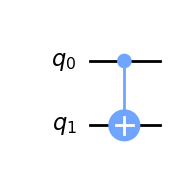

In [36]:
# Let's first build an elementary circuit with CNOT gate

qc = QuantumCircuit(2)

# Apply a CNOT gate (CX gate) on qubit 1 controlled by qubit 0
qc.cx(0, 1)

qc.draw('mpl')

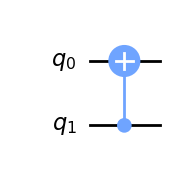

In [37]:
# We may as well alter the order, making q0 the control qubit and q1 the target qubit

qc = QuantumCircuit(2)

# Apply a CNOT gate (CX gate) on qubit 0 controlled by qubit 1
qc.cx(1, 0)

qc.draw('mpl')

Now let's say we want to run basic tests on this circuit. Here, q0 will get inverted if q1 is in state |1>. To test, let us first apply a Pauli-X gate (which is equivalent to classical NOT) on q1. Then let's see whether both of them measure to be in the state |1>.

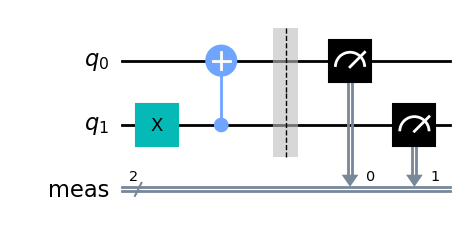

In [38]:
qc = QuantumCircuit(2)

# Apply a CNOT gate (CX gate) on qubit 0 controlled by qubit 1
qc.x(1)
qc.cx(1, 0)

qc.measure_all()

qc.draw('mpl')

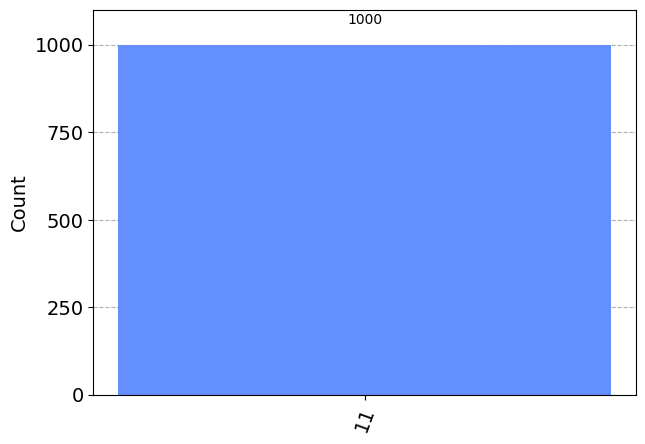

In [39]:
result = get_result_from_backend(qc)

# Get the counts of the measurements
counts = result.get_counts()

# Plot the histogram
plot_histogram(counts)

As expected, both of the qubits end up to be measured at |1>

# Matching the Matrix

In [40]:
# Let's now run the circuit in the simulator and see whether the unitary matrix matches with what we have learnt.

qc = QuantumCircuit(2)

qc.cx(1, 0)

print(get_unitary_matrix(qc))

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


Please note that the matrix would change if we swapped the order of the control and target qubits. Let's do and check.

In [41]:
qc = QuantumCircuit(2)

qc.cx(0, 1)

print(get_unitary_matrix(qc))

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


# Visualization in Bloch Sphere

Now let us observe the state vector of each qubit at subsequent stages of building the circuit.

One important thing to consider while interpreting the output state vectors is that, when a qubit is measured, it loses the superposition and attains a random state between |0> and |1> as the observation. This is important because, if we put measuring devices and we also want to have the superposition like state vector, it will not give us the correct or expected output.

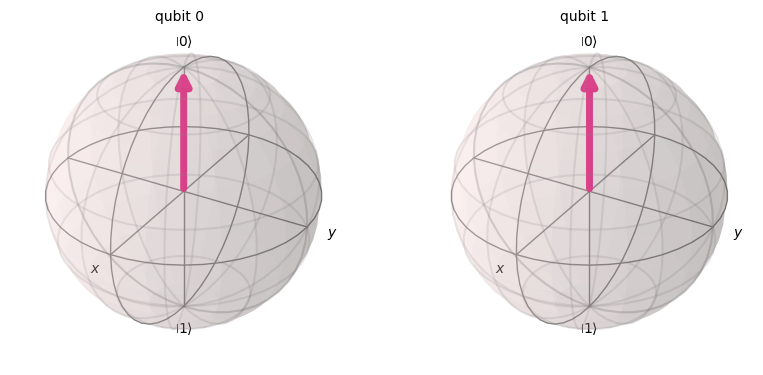

In [42]:
qc = QuantumCircuit(2)

plot_bloch_multivector(get_state_vector(qc))

# First, both of them are at the state |0>

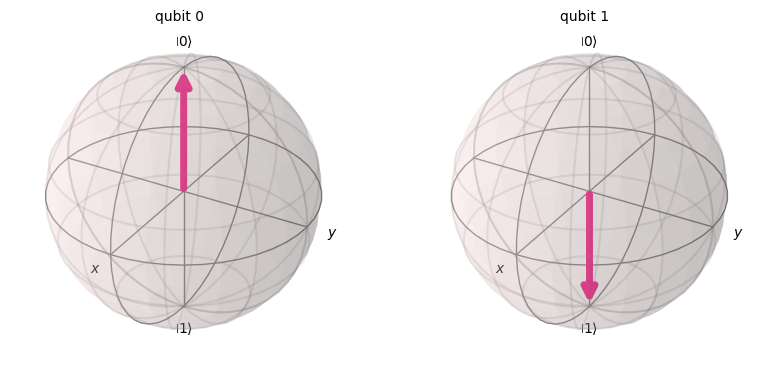

In [43]:
qc.x(1)
plot_bloch_multivector(get_state_vector(qc))

# Afterwards, when we apply Pauli-X on qubit 1, its state vector should point downwards, thereby indication the state |1>

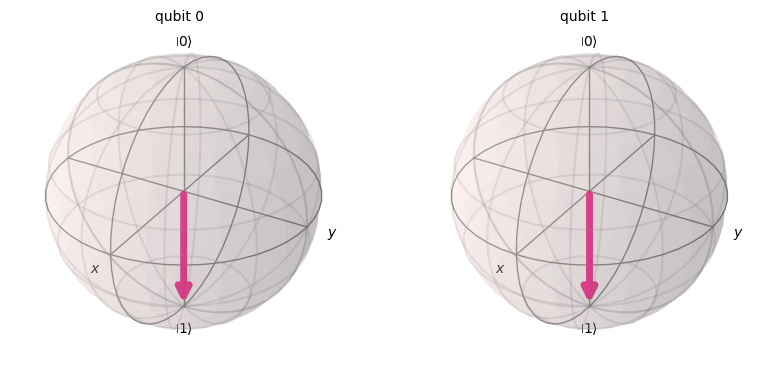

In [44]:
qc.cx(1,0)
plot_bloch_multivector(get_state_vector(qc))

# Then we apply the CNOT gate with q1 as control qubit and q0 as target qubit

Great! Out observations match with theoretical expectations.

Can you say what the output statevectors would look like if we swapped the order of control and target qubit keeping others same. Let's experiment.

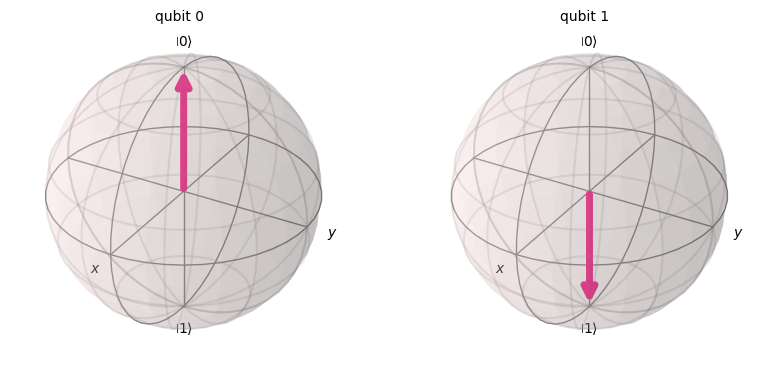

In [45]:
qc = QuantumCircuit(2)

qc.x(1)
qc.cx(0, 1)

plot_bloch_multivector(get_state_vector(qc))

As expected, since the control qubit is now q0 and since q0 is in state |0>, it will not alter the target qubit.

# How to think

To put it simply, whenever, we need something like a = a XOR b, we may safely incorporate a CNOT gate with b as the control qubit and a as the target qubit.

But what if, we need to do more.

Let's say, for some calculation, we need a = a XOR b XOR c

where, a,b,c will obviously be replaced by quantum bits.

Turns out, we can easily do it with adding two CNOT gates in succession. Think like this, we can simply rewrite our requirement as a = (a XOR b) XOR c

Thus we will first apply CNOT with b as control and a as target. Then we will again apply CNOT with c as control and again a as target. Let's build it.

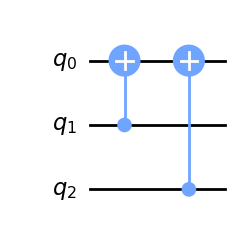

In [46]:
qc = QuantumCircuit(3)

qc.cx(1,0)
qc.cx(2,0)

qc.draw('mpl')

To test, let's say, we set both q1 and q2 to be at |1>.

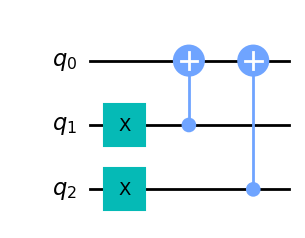

In [56]:
qc = QuantumCircuit(3)

qc.x(1)
qc.x(2)
qc.cx(1,0)
qc.cx(2,0)

qc.draw('mpl')

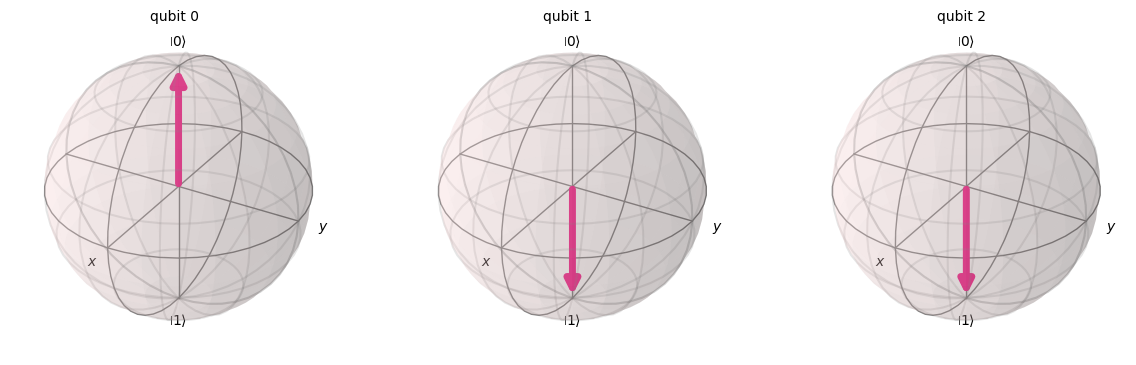

In [57]:
plot_bloch_multivector(get_state_vector(qc))

As expected, q0 does not change since q1 XOR q2 is not in state |1>.

Now let's flip q2 back to state |0>. In other words, let's remove the X=gate after q2. When we run, the state of q0 should also get flipped.

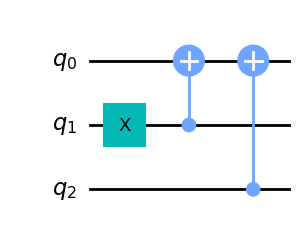

In [58]:
qc = QuantumCircuit(3)

qc.x(1)
qc.cx(1,0)
qc.cx(2,0)

qc.draw('mpl')

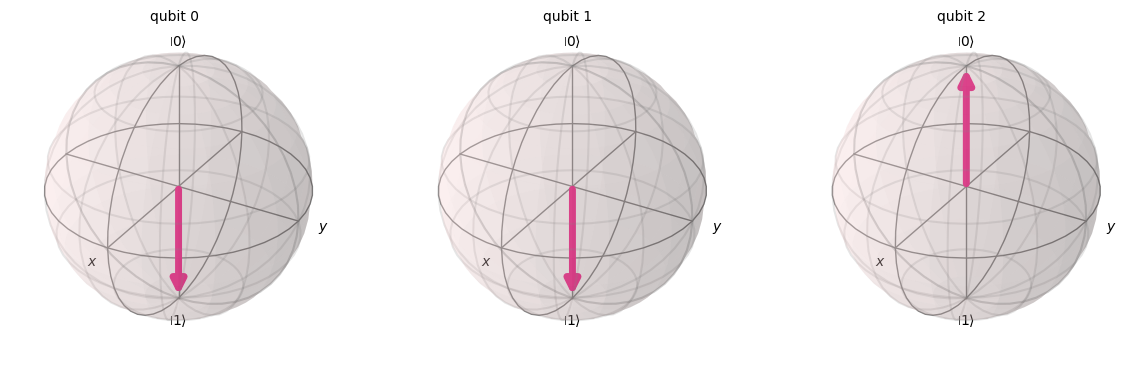

In [59]:
plot_bloch_multivector(get_state_vector(qc))

Yes, it works.